In [3]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')

diabetes_data = pd.read_csv('diabetes_cleaned.csv')
diabetes_data.head()
diabetes_data.shape

(757, 8)

посмотрим на матрицу корреляций и выберем наиболее коррелированные с целевым признаком факторы:

<Axes: >

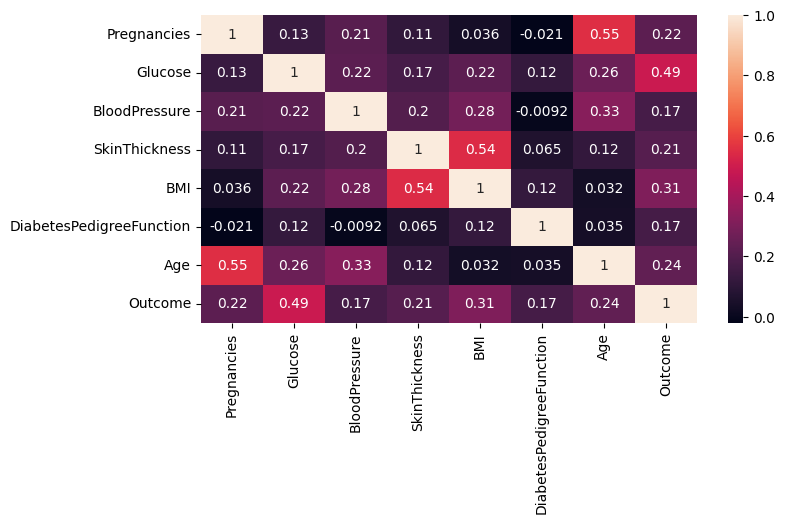

In [4]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(diabetes_data.corr(), annot=True)

Из строки Outcome видно, что наибольшей корреляцией с целевым признаком обладают факторы Glucose (уровень глюкозы) и BMI (индекс массы тела).

Построим диаграмму рассеяния, по оси абсцисс отложим фактор Glucose, а по оси ординат — BMI. Сделаем цветовую группировку по признаку наличия диабета:

Text(0.5, 1.0, 'Scatter Plot for Glucose VS BMI')

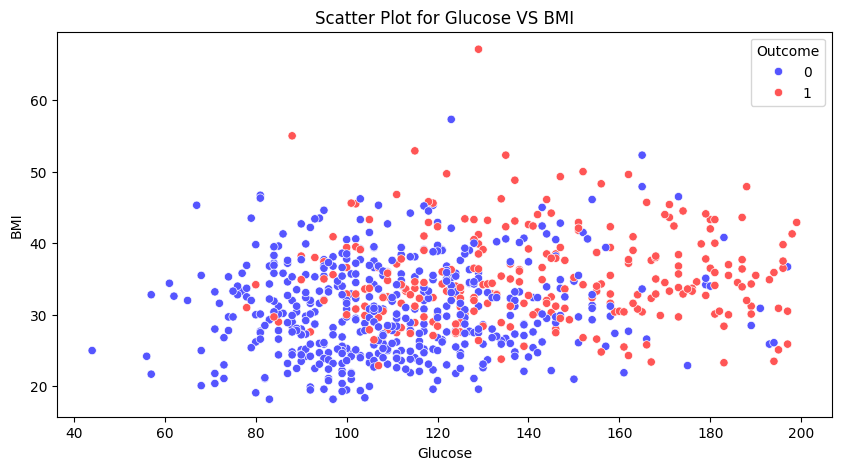

In [5]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);

#Задаём название графику
ax.set_title('Scatter Plot for Glucose VS BMI')

Видно, что классы довольно сильно перемешаны, но красные точки, соответствующие пациентам с диабетом, преимущественно сгруппированы в правой части системы координат.

Давайте попробуем построить разделяющую плоскость с помощью логистической регрессии.

Для начала разделим выборку на матрицу наблюдений X, состоящую из двух признаков, и столбец с правильным ответами y:

In [6]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']
from sklearn import linear_model #линейные модели

In [8]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42) #random_state — число, на основе которого происходит генерация случайных чисел.
#Обучаем модель, минимизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


Как нам сделать предсказание вероятности наличия диабета у пациента?

Мы должны подставить значения факторов в уравнение разделяющей плоскости, а затем результат подставить в функцию сигмоиды. Как хорошо, что для этого есть метод predict_proba().

Например, появился новый пациент с концентрацией глюкозы 180 мг/100мл и индексом массы тела в 
51 кг/м. Мы хотим вычислить вероятность наличия/отсутствия диабета у данного пациента:

In [9]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод predict_proba() возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

Если мы хотим предсказать не вероятности, а сам класс (1 или 0), нам пригодится метод predict(). По умолчанию метод predict() относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [10]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))
# Predicted class: [1]

Predicted class: [1]


Предсказанный класс равен 1: значит, модель считает, что данный пациент болеет диабетом.

Теперь построим визуализацию нашей модели.

Чтобы красиво визуализировать вероятности в виде тепловой карты, мы подготовили для вас специальную функцию — plot_probabilities_2d().

Данная функция принимает три аргумента:

X — матрица с наблюдениями,
y — столбец с правильными ответами,
model — модель, с помощью которой делается предсказание вероятностей.

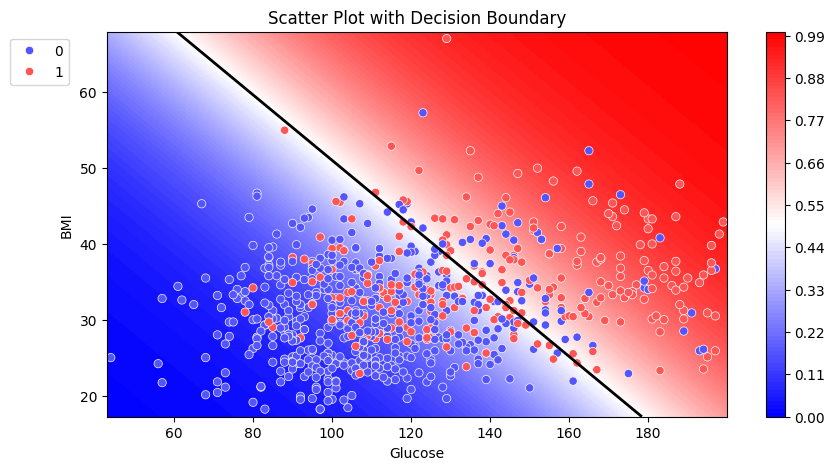

In [12]:
# Это не обязательно!!!!!!!!!!!!
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
plot_probabilities_2d(X, y, log_reg_2d)

Из графика видно, что довольно много синих точек попали в красную зону и наоборот. Видимо, информации о двух факторах всё же маловато для того, чтобы хорошо провести классификацию.

Давайте будем использовать для построения модели всю предоставленную нам информацию — все факторы из набора данных. Для этого заново создадим матрицу наблюдений X и вектор ответов y:

In [13]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

Сделаем предсказание вероятности заболевания диабетом для каждого пациента и самих классов с помощью методов predict_proba() и predict().

In [14]:
#Создаём объект класса LogisticRegression
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg_full.fit(X, y)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X)

Затем добавим предсказание в таблицу X для наглядности:

In [15]:
#Создадим временную таблицу X
X_temp = X.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
752            5    139.0           64.0           35.0  28.6   
753            1     96.0          122.0           29.0  22.4   
754           10    101.0           86.0           37.0  45.6   
755            0    141.0           72.0           29.0  42.4   
756            0    125.0           96.0           29.0  22.5   

     DiabetesPedigreeFunction  Age  Prediction  
752                     0.411   26           0  
753                     0.207   27           0  
754                     1.136   38           1  
755                     0.205   29           1  
756                     0.262   21           0

Но как же тогда узнать, насколько хорошо модель определяет наличие диабета у пациента? Для этого используются метрики классификации, о которых мы поговорим в следующем юните.

In [16]:
#Делаем предсказание моделью, обученной на двух признаках 
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])
#Делаем предсказание моделью, обученной на всех признаках 
y_pred2 = log_reg_full.predict(diabetes_data.drop('Outcome', axis=1))

Text(627.9949494949494, 0.5, 'y true')

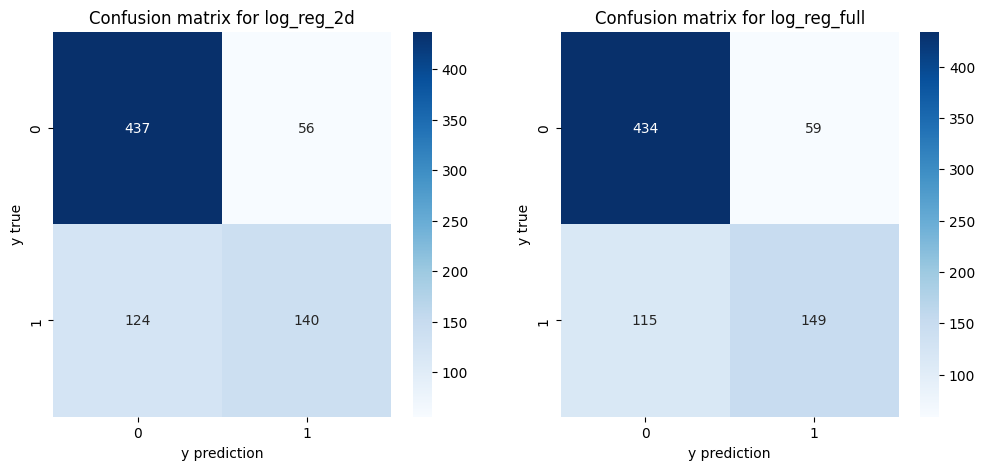

In [18]:
from sklearn import metrics
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true')

Расчёт метрик для модели log_reg_2d, обученной на двух факторах — Glucose и BMI:

In [19]:
#Модель log_reg_2d:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


Расчёт метрик для модели log_reg_full, обученной на всех доступных факторах:

In [20]:
#Модель log_reg_full:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


Видно, что хоть и с небольшим отрывом, но вторая модель, обученная по всем признакам, превосходит первую модель по всем метрикам.

In [21]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



Сделаем предсказание вероятности наличия диабета моделью log_reg_full для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [22]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop('Outcome', axis=1))[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

Теперь у нас есть три списка (recall_scores, precision_scores и f1_scores), в которых хранятся значения метрик при различных значениях порога вероятности .

Давайте построим графики зависимости метрик от порога вероятности:

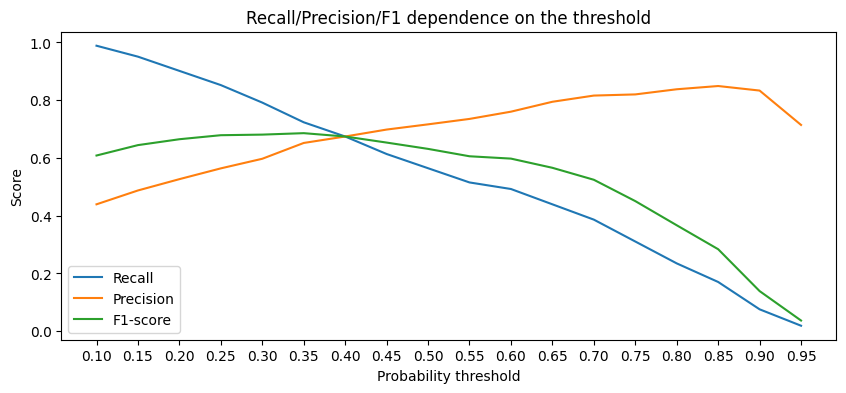

In [23]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend()

С увеличением вероятностного порога повышается precision и падает recall.

Мы делаем предсказание вероятности наличия диабета для всех пациентов, а затем вручную определяем всех пациентов, у которых эта вероятность > 0.4, в класс 1, а остальных — в класс 0. Далее считаем метрики:

In [24]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.4
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       493
           1       0.67      0.67      0.67       264

    accuracy                           0.77       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.77      0.77      0.77       757

